# Pathway Analysis
![](./images/Module4/PathwayAnalysis.jpg)

Enrichment analysis (EA) is a technique used to derive biological insight from lists of significantly altered genes. The list of genes can be obtained from Differential Expression (DE) analysis or users' interest. The EA methods rely on the knowledge databases (e.g. KEGG, GO, ...) to identify biological pathways or terms that are enriched in a gene list more than would be expected by chance. The outcome of the EA would be the in-depth and contextualized findings to help understand the mechanisms of disease, genes and proteins associated with the etiology of a specific disease or drug target.

Over more than a decade, there are over 50 methods have been developed for EA. In this module, we will focus on pathway analysis using popular methods including Over Representation Analysis (ORA), Correlation Adjusted MEan RAnk (CAMERA), Kolmogorov-Smirnov (KS) test, Wilcoxon test, Fast Gene Set Enrichment Analysis (FGSEA), Gene Set Analysis (GSA), Significance Analysis of Function and Expression (SAFE), and Pathway Analysis with Down-weighting of Overlapping Genes (PADOG).

## Learning Objectives
1. Data preparation
2. Perform enrichment analysis using ORA, CAMERA, KS, Wilcoxon, FGSEA, GSA, SAFE, and PADOG
3. Visualize and interpret the outputs

### Table of Contents

1. [Enrichment Analysis using ORA](#ora-main)
2. [Enrichment Analysis using CAMERA](#camera-main)
3. [Enrichment Analysis using KS and Wilcoxon test](#ks-main)
4. [Enrichment Analysis using FGSEA](#fgsea-main)
5. [Enrichment Analysis using GSA](#gsa-main)
6. [Enrichment Analysis using SAFE](#safe-main)
7. [Enrichment Analysis using PADOG](#padog-main)


<!-- 
## Necessary Files
In this submodule, users will have to provide the following inputs: 
- (1) Gene expression/count matrix in which, rows are genes and columns are samples and a differential analysis result, also in the form of a matrix. We recommend using gene ID as gene SYMBOL. If users use other different gene ID types, please refer to [our first submodule](./Module01-Data_Preparation.ipynb). 
for the instructions for gene mapping.
- (2) A table of sample information that has at least two columns: sample ID that matched the columns of the first input, and sample condition (e.g, control or disease)
- (3) A list of gene sets to used for the enrichment analysis. Please check out our [previous submodule](./Module01-Data_Preparation.ipynb) for more information of the format for the gene sets.

If users have been following our learning submodules, they only need to use the code available in the previous module to download the data from Google Cloud Bucket and load it for the analyses.
 -->



In [1]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-1.html" width=100% height=250></iframe>')

### Data downloading
In this submodule, we will use the DE genes of `limma` analysis result of the `GSE5281` dataset from [**submodule 02** ](./Submodule02-DifferentialAnalysis.ipynb) and the `.gmt` files containing GO terms, KEGG pathways, REACTOME pathways gene sets created in [**submodule 03** ](./Submodule03-ProcessingPathwayInformation.ipynb) for performing enrichment analysis.
We can use the following command to download the data from Google Cloud Bucket.

In [2]:
# Download the GSE48350.rds file to the "data" folder in current directory
system("gsutil cp gs://ccpa_bucket/GSE5281.rds ./data/")

# Download the GO_terms.gmt, KEGG_pathways.gmt, REACTOME_pathways.gmt files to the "data" folder in current directory
system("gsutil cp gs://ccpa_bucket/GO_terms.gmt ./data/")
system("gsutil cp gs://ccpa_bucket/KEGG_pathways.gmt ./data/")
system("gsutil cp gs://ccpa_bucket/REACTOME_pathways.gmt ./data/")

We can now load the DE analysis result using the following commands.

In [3]:
# Load previously saved data
data <- readRDS("./data/GSE5281.rds")
# To see what are available in data
names(data)

# Get DE results from the loaded data
DE.df <- data$limma_results
# Print some first row of the differential analysis result
head(DE.df)

[1] "expression_data" "samples"         "genes"           "limma_results"  
[5] "tTest_results"   "edgeR_results"   "deseq2_results"

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TUBB,TUBB,1.432179e-22,3.177289e-18,-11.36377,-1.631276,9.123189
PSMB3,PSMB3,2.388997e-21,1.829653e-17,-10.92825,-1.408793,8.736749
TUBB4B,TUBB4B,2.474176e-21,1.829653e-17,-10.92281,-1.726316,10.297977
SLC35E1,SLC35E1,7.401763e-21,4.105203e-17,10.75253,1.627450,11.470567
ATP5F1C,ATP5F1C,9.950015e-21,4.414822e-17,-10.70648,-1.881757,10.012823
ATP5F1B,ATP5F1B,2.802296e-20,1.036149e-16,-10.54504,-1.616196,10.576243


<!-- headings -->
<a id="ora-main"></a>
## 1. Enrichment Analysis Using Over-Representation Analysis
Over-representation analysis (ORA) is a statistical method that determines whether genes from a pre-defined gene set of a specific GO term or KEGG pathway are presented more than would be expected (over-represented) in a subset of your data. In our learning module, this subset refers to the list of DE genes generated from the `limma` method. For each gene set, an enrichment *p-value* is calculated using the Binomial distribution, Hypergeometric distribution, the Fisher exact test, or the Chi-square test.  The hypergeometric distribution is a popular approach used to calculate enrichment p-value. The formula can be presented as follows:

$$
     P(X\geq x) = 1 - P(X \leq x-1) = 1 - \sum\limits_{i=0}^{x-1}\frac{\hphantom{}{M \choose i }{N - M \choose n-i}}{N \choose n}
$$

where *N* is the number of background genes (all genes presented in the expression matrix), *n* is the number of “interesting” genes (DE genes), *M* is the number of genes that are annotated to a particular gene set *S* (list of genes in a specific KEGG pathway or GO term), and *x* is the number of “interesting” genes that are annotated to *S* (genes presented in DE genes list and a specific KEGG pathway or GO term).

For example, suppose we have an expression matrix with 20,000 genes, of which 500 are differently expressed. Also, suppose that 100 of the 20,000 genes are annotated to a particular gene set S. Of these 100 genes, 20 are members of the DE genes list. The probability that 20 or more (up to 100) genes annotated to S are in the DE genes list by chance is given by

$$
P(X\geq 20) = 1 - P(X \leq 19) = 1-\sum \limits_{i=0}^{19}\frac{\hphantom{}{100 \choose i}{20000 - 100 \choose 500-i}}{20000 \choose 500} = 5.26 \times 10^{-13}
$$

The *p-value* indicates that it is very rare to observe 20 of the 100 genes from this set are in the DE genes list by chance.

In [4]:
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-2.html" width=100% height=250></iframe>')

### Data preparation
To conduct enrichment analysis using ORA, there are several input data that we need to prepare. First, we need to select a set of genes that
are significantly altered (*p-value < 0.05*) in the DE genes generated from the `limma` method.

In [5]:
# Selecting a list of significant DE genes
DEGenes <- DE.df[DE.df$pFDR <= 0.05, ]
# Select the remaining genes 
DEGenes <- DEGenes$SYMBOL

Next, we need to define a list of background genes. In this analysis, they are all the genes generated from the DE analysis.

In [6]:
# Defining background genes
backgroundSet <- DE.df$SYMBOL

Then, we need to obtain a list of geneset from knowledge databases such as GO and KEGG. In this learning module, the geneset will be retrieved from
the *.gmt* files that were processed from the [**submodule 03**](./Submodule03-ProcessingPathwayInformation.ipynb). To load the geneset, we will use the `gmt2geneset` function below:

In [7]:
#' @description This function read a GMT file to a gene sets list in R
#'
#' @param path The file path to the GMT file.
#' @return A list containing the gene sets extracted from the GMT file.

gmt2geneset <- function(path) {
    # Read the lines from the file
    lines <- readLines(path, warn = FALSE)

    # Split each line into fields
    gmt_data <- strsplit(lines, "\t")

    # Process each line and extract gene sets
    gene_sets <- lapply(gmt_data, function(line) {
        gene_set_name <- line[1]
        description <- line[2]
        genes <- line[-c(1, 2)]  # Exclude the first two elements (name and description)

        list(
            pathwayID = gene_set_name,
            description = description,
            genes = genes
        )
    })
    # Convert list of gene sets to a named list
    gs <- lapply(gene_sets, function(g) g$genes)
    names(gs) <- lapply(gene_sets, function(g) g$pathwayID)

    return(gs)
}

Here, we also use a function called `runORA` to perform over-representation analysis based on the hyper-geometric testing formula presented above.
It requires a list of gene sets (E.g. GO terms, KEGG, REACTOME, ...), a dataframe containing results of a DE analysis method and a p-value threshold for a gene to be considered differentially expressed. The `ORA` method will perform hyper-geometric testing for each geneset obtained from GO or KEGG using the function `phyper` available for the `stats` R base package. The output of the `.runORA` function is a table that contains a column of terms or pathway names and a column of *p-value*.

In [8]:
#' @description This function performs gene set analysis based on ORA (Over Representation Analysis).
#'
#' @param DE_data The generated SummarizedExpriment object from DE analysis result.
#' @param genesets The gene to use for the analysis, e.g. KEGG gene sets from gmt2geneset function.
#' @param pThreshold The p.value cutoff threshold.
#' @return A dataframe of geneset analysis results

runORA <- function(DE_data, genesets, pThreshold = 0.05) {    
    # Check if DE_data is not null and has dimensions
    if (is.null(DE_data) |
        dim(DE_data)[1] == 0 |
        dim(DE_data)[2] == 0) {
        stop("No differential analysis data is in input data.")
    }

    # Extract genes with p-values below the threshold
    DE.genes <- rownames(DE_data[DE_data$p.value <= pThreshold, ])
        
    # All genes in the background
    background.genes <- rownames(DE_data)

    # Calculate the overlap between genesets and background genes
    GSOverlap <- sapply(genesets, function(gs) length(intersect(gs, background.genes)))
    # Calculate the overlap between genesets and differentially expressed genes
    DEOverlap <- sapply(genesets, function(gs) length(intersect(gs, DE.genes)))
    # Calculate the number of non-differentially expressed genes in the background
    NoneDEInBackground <- length(background.genes) - length(DE.genes)
    # Calculate the expected overlap by chance
    Expected <- GSOverlap * length(DE.genes) / length(background.genes)

    # Calculate p-values using hypergeometric distribution
    pvals <- 1 - phyper(DEOverlap - 1, length(DE.genes), NoneDEInBackground, GSOverlap)
    # Calculate Enrichment Score (ES)
    ES <- log2(DEOverlap / Expected)

    # Create a dataframe with results
    result_df <- data.frame(
        ID = names(genesets),
        p.value = pvals,
        score = ES,
        normalizedScore = ES, # For now, normalized score is the same as ES
        stringsAsFactors = FALSE
    )

    return(result_df)
}


### Enrichment analysis using ORA and GO terms
In this section, we will perform ORA using the list of gene sets obtained from the GO database and the function `ORA` defined above. The detailed code is presented below:

In [9]:
# Loading GO terms
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# Perform ORA
ORA_res <- runORA(DE_data = DE.df, genesets = geneset, pThreshold = 0.05)

# Order the table based on the p-value
ORA_res <- ORA_res[order(ORA_res$p.value), ]
# View the most significant GO terms
head(ORA_res)

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
GO:0006139,GO:0006139,0,0.2080449,0.2080449
GO:0006412,GO:0006412,0,0.5071833,0.5071833
GO:0006518,GO:0006518,0,0.4688192,0.4688192
GO:0006725,GO:0006725,0,0.1971205,0.1971205
GO:0006807,GO:0006807,0,0.2204049,0.2204049
GO:0006810,GO:0006810,0,0.1916887,0.1916887


From the result table, we might conclude that the pathways shown are key components of the disease in study.

### Enrichment analysis using ORA and KEGG pathways

We will perform the same steps as we did above with the GO terms.

In [10]:
# Loading KEGG pathways
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})

# Perform Hyper-geometric testing
ORA_res <- runORA(DE_data = DE.df, genesets = geneset, pThreshold = 0.05)

# # Order the table based on the p-value
ORA_res <- ORA_res[order(ORA_res$p.value), ]
# View the most significant GO terms
head(ORA_res)


,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
hsa05012,hsa05012,0.000000e+00,0.8215426,0.8215426
hsa05014,hsa05014,0.000000e+00,0.6829997,0.6829997
hsa05016,hsa05016,0.000000e+00,0.7605060,0.7605060
hsa05022,hsa05022,4.440892e-16,0.5601445,0.5601445
hsa05020,hsa05020,7.549517e-15,0.6837973,0.6837973
hsa03050,hsa03050,2.984279e-13,1.2308632,1.2308632


### Enrichment analysis using ORA and REACTOME pathways

We will perform similar steps as we did before with the GO terms and KEEG pathways.

In [11]:
# Loading REACTOME pathways
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# Perform ORA
ORA_res <- runORA(DE_data = DE.df, genesets = geneset, pThreshold = 0.05)

# Order the table based on the p-value
ORA_res <- ORA_res[order(ORA_res$p.value), ]
# View the most significant GO terms
head(ORA_res)

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
R-HSA-72766,R-HSA-72766,0,0.7507580,0.7507580
R-HSA-163200,R-HSA-163200,0,0.9698630,0.9698630
R-HSA-199991,R-HSA-199991,0,0.5353433,0.5353433
R-HSA-392499,R-HSA-392499,0,0.3888270,0.3888270
R-HSA-611105,R-HSA-611105,0,1.0542352,1.0542352
R-HSA-1428517,R-HSA-1428517,0,0.8847324,0.8847324


<!-- headings -->
<a id="camera-main"></a>
## 2. Enrichment Analysis using CAMERA

Correlation Adjusted MEan RAnk (CAMERA) is a powerful gene set analysis method designed for high-throughput genomic data. It operates in two stages, first calculating gene-level statistics including fold change, t-statistic, moderated t-statistics, and a normalized moderated t-statistic using a linear model. In the second stage, The inter-gene correlation within gene sets is assessed through the computation of the variance inflation factor (VIF), and this information is then integrated into either parametric or rank-based hypothesis tests.

Since we already had the gene-level statistics from DE analysis in submodule 2, We can utilize the `cameraPR` function integrated in `limma` package to perform the second stage of CAMERA. The `runCAMERA` function below is provided to perform analysis using CAMERA method.

In [12]:
# Import the limma package
library(limma)

In [13]:
#' @description This function performs gene set analysis using CAMERA method.
#'
#' @param DE_data A dataframe containing the DE analysis result.
#' @param genesets A list of gene sets to be analyzed.
#' @param stat_col A character string specifying the name of a statistic column in DE_data
#'                 to be used in the EA analysis.
#' @param use.ranks A logical whether to use parametric or rank-based hypothesis test
#' @return A dataframe containing the results of the tests for each gene set.

runCAMERA <- function(DE_data, genesets, stat_col = "statistic", use.ranks = FALSE) {
  
    # Extract the statistics column from DE_data
    stats <- DE_data[, stat_col]
    # Set gene names as row names for stats
    names(stats) <- rownames(DE_data)
    # Run CAMERA analysis using cameraPR function
    CAMERA_res <- cameraPR(statistic = stats, index = genesets, use.ranks = use.ranks)
    # Create a dataframe with results
    result_df <- data.frame(
        ID = rownames(CAMERA_res),
        p.value = CAMERA_res$PValue,
        pFDR = CAMERA_res$FDR,
        stringsAsFactors = FALSE
    )
    # Return the result dataframe
    result_df
}


### Enrichment analysis using CAMERA and GO terms
We will use the `runCAMERA` function to perform gene set analysis with GO terms as follows:

In [14]:
# Loading GO terms
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# Perform EA using CAMERA method
CAMERA_res <- runCAMERA(DE_data = DE.df, genesets = geneset, stat_col = "statistic")
head(CAMERA_res)

,ID,p.value,pFDR
,<chr>,<dbl>,<dbl>
1,GO:0042773,1.452114e-18,5.037383e-15
2,GO:0042775,1.452114e-18,5.037383e-15
3,GO:0015986,1.351633e-17,3.125877e-14
4,GO:0019646,4.263260e-17,7.394624e-14
5,GO:0009145,3.894336e-16,5.403781e-13
6,GO:0032543,6.164403e-16,6.681384e-13


### Enrichment analysis using CAMERA and KEGG pathways

To analyze the KEGG pathways using CAMERA, we can use the same above codes and simply replace GO terms with KEGG pathways.

In [15]:
# Loading KEGG pathways
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})
# Perform EA using CAMERA method
CAMERA_res <- runCAMERA(DE_data = DE.df, genesets = geneset, stat_col = "statistic")
head(CAMERA_res)

,ID,p.value,pFDR
,<chr>,<dbl>,<dbl>
1,hsa03050,2.620282e-21,9.039974e-19
2,hsa00190,2.075698e-18,3.580579e-16
3,hsa05012,4.282708e-15,4.925115e-13
4,hsa05016,1.491982e-13,1.286834e-11
5,hsa05020,1.004145e-12,6.928604e-11
6,hsa05014,2.878336e-12,1.655043e-10


### Enrichment analysis using CAMERA and REACTOME pathways

Similar to GO terms and KEGG pathways, we just need to load and pass the REACTOME pathways to the `runCAMERA` function.

In [16]:
# Loading REACTOME pathways
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# Perform EA using CAMERA method
CAMERA_res <- runCAMERA(DE_data = DE.df, genesets = geneset, stat_col = "statistic")
# Show some first rows of the result data frame
head(CAMERA_res)

,ID,p.value,pFDR
,<chr>,<dbl>,<dbl>
1,R-HSA-9604323,2.644210e-22,6.941051e-19
2,R-HSA-180585,1.032521e-21,1.318308e-18
3,R-HSA-9762114,1.506638e-21,1.318308e-18
4,R-HSA-211733,3.761629e-21,2.468569e-18
5,R-HSA-8854050,1.726367e-20,8.870846e-18
6,R-HSA-174113,2.314618e-20,8.870846e-18


<!-- headings -->
<a id="ks-main"></a>
## 3. Enrichment Analysis using KS and Wilcoxon test

The Kolmogorov-Smirnov (KS) test is a non-parametric test that compares the cumulative distribution functions of two datasets. In the context of enrichment analysis, it can be employed to assess whether the distribution of DE genes is significantly different from what would be expected by chance for a given gene set. The test produces a KS statistic and a corresponding p-value, indicating the degree of over-representation.

The Wilcoxon test, also called the Mann-Whitney U test, helps us check if the ranks of certain genes (DE genes) are significantly different from the rest of the genes. It's a sturdy non-parametric method that doesn't rely on specific assumptions about data distribution. By looking at the ranks, it tells us if there are meaningful differences in how these genes are positioned compared to the overall set. In the context of enrichment analyses, the Wilcoxon test emerges as a valuable tool, elucidating critical variations in the hierarchical arrangement or ranking of genes within the dataset.

### Data preparation
To conduct enrichment analysis using KS or Wilcoxon test, we will use the limma DE result as input. First, we can use the DE.df variable above and select a set of genes that
are significantly altered (*p-value < 0.05*). 

In [17]:
# Select genes that are significantly altered
kw_de <- DE.df[DE.df$pFDR <= 0.05, ]
# Show some first rows
head(kw_de)

,SYMBOL,p.value,pFDR,statistic,logFC,avgExpr
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TUBB,TUBB,1.432179e-22,3.177289e-18,-11.36377,-1.631276,9.123189
PSMB3,PSMB3,2.388997e-21,1.829653e-17,-10.92825,-1.408793,8.736749
TUBB4B,TUBB4B,2.474176e-21,1.829653e-17,-10.92281,-1.726316,10.297977
SLC35E1,SLC35E1,7.401763e-21,4.105203e-17,10.75253,1.627450,11.470567
ATP5F1C,ATP5F1C,9.950015e-21,4.414822e-17,-10.70648,-1.881757,10.012823
ATP5F1B,ATP5F1B,2.802296e-20,1.036149e-16,-10.54504,-1.616196,10.576243


Next, we will remove rows containing NA, dupicated symbols.

In [18]:
# Remove NA value
kw_de <- kw_de[!is.na(kw_de$SYMBOL), ]
# Remove duplicated genes symbols
kw_de <- kw_de[!duplicated(kw_de$SYMBOL, fromLast = FALSE), ]
rownames(kw_de) <- kw_de$SYMBOL
# remove the first column from the DE dataframe  
kw_de <- kw_de[, !(names(kw_de) %in% c("SYMBOL"))]
# Show some first rows
head(kw_de)

,p.value,pFDR,statistic,logFC,avgExpr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TUBB,1.432179e-22,3.177289e-18,-11.36377,-1.631276,9.123189
PSMB3,2.388997e-21,1.829653e-17,-10.92825,-1.408793,8.736749
TUBB4B,2.474176e-21,1.829653e-17,-10.92281,-1.726316,10.297977
SLC35E1,7.401763e-21,4.105203e-17,10.75253,1.627450,11.470567
ATP5F1C,9.950015e-21,4.414822e-17,-10.70648,-1.881757,10.012823
ATP5F1B,2.802296e-20,1.036149e-16,-10.54504,-1.616196,10.576243


To perform KS or Wilcoxon test, we will use the `runKsWilcox` function bellow.

In [19]:
#' Run Kolmogorov-Smirnov Wilcoxon rank-sum test on differential expression data
#'
#' @param DE_data A dataframe containing the DE analysis result.
#' @param statCol A character string specifying the name of a statistic column in DE_data to be used in the EA analysis.
#' @param genesets A list of gene sets to be analyzed.
#' @param sTest The type of test to be used ("ks" for Kolmogorov-Smirnov, "wilcox" for Wilcoxon rank-sum).
#' @return A dataframe containing the results of the tests for each gene set.

runKsWilcox <- function(DE_data, genesets, statCol = "statistic", sTest = "ks") {
    # remove rows that contain NA value in the column specified by the statCol argument
    DE_data <- DE_data[!is.na(DE_data[[statCol]]), ]
    # get the statistical values from DE_data to perform the test
    ranks <- DE_data[[statCol]]
    # set names of the DE genes
    names(ranks) <- rownames(DE_data)

    # choose the test to perform based on the sTest argument
    test <- if (sTest == "ks") ks.test else wilcox.test
    
    background.genes <- rownames(DE_data)
    # retrieve statistics for genes present in 'background.genes'
    DEhit <- sapply(genesets, function(gs) ranks[background.genes[background.genes %in% gs]])
    # retrieve statistics for genes not present in 'background.genes'
    DEmiss <- sapply(genesets, function(gs) ranks[background.genes[!background.genes %in% gs]])

    # Initialize an empty list to store results
    PA_res_list <- lapply(1:length(DEhit), function(i) {
        cur.DEhit <- DEhit[[i]]
        cur.DEmiss <- DEmiss[[i]]
    
        # Check if either list is empty
        if (length(cur.DEhit) == 0 | length(cur.DEmiss) == 0) return(1)
    
        # Perform the test and extract the p-value
        test_result <- suppressWarnings(test(cur.DEhit, cur.DEmiss))
        test_result$p.value
    })
    
    # Combine the results into a data frame
    PA_res <- data.frame(
        ID = names(genesets),
        p.value = unlist(PA_res_list),
        stringsAsFactors = FALSE
    )
    
    # Remove rows with missing values
    PA_res <- PA_res[complete.cases(PA_res), ]

    return(PA_res)
}

### Enrichment analysis using KS and GO terms

We will conduct KS enrichment analysis with GO terms gene sets list using the provided code.

In [20]:
# load the GO gene sets from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# perform enrichment analysis using KS test
suppressWarnings(k_results <- runKsWilcox(DE_data = kw_de, geneset = geneset, statCol = "statistic", sTest = "ks"))

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result 
head(k_results)

,ID,p.value
,<chr>,<dbl>
632,GO:0006091,0
1189,GO:0008150,0
1254,GO:0009060,0
3001,GO:0035239,0
3011,GO:0035295,0
3722,GO:0045333,0


### Enrichment analysis using KS and KEGG pathways
To do the analysis with KEEG pathways, we will replace the GO gene sets list with the KEGG pathways.

In [21]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})
# perform enrichment analysis using KS test
k_results <- runKsWilcox(DE_data = kw_de, geneset = geneset, statCol = "statistic", sTest = "ks")

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result 
head(k_results)

,ID,p.value
,<chr>,<dbl>
15,hsa00190,0
319,hsa05010,0
320,hsa05012,0
321,hsa05014,0
322,hsa05016,0
324,hsa05020,0


### Enrichment analysis using KS and REACTOME pathways
To do the analysis with REACTOME pathways, we will use the same steps as for GO terms and KEEG pathways.

In [22]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})
# perform enrichment analysis using KS test
k_results <- runKsWilcox(DE_data = kw_de, geneset = geneset, statCol = "statistic", sTest = "ks")

# order the results 
k_results <- k_results[order(k_results$p.value), ]
# show some first rows of the result table
head(k_results)

,ID,p.value
,<chr>,<dbl>
95,R-HSA-72766,0.000000e+00
742,R-HSA-392499,0.000000e+00
1079,R-HSA-1428517,0.000000e+00
1080,R-HSA-1430728,0.000000e+00
306,R-HSA-163200,5.551115e-16
2087,R-HSA-8953854,6.661338e-16


### Enrichment analysis using WILCOXON and GO terms

For enrichment analysis with Wilcoxon test, we will pass the value "wilcox" to the *sTest* argument in the `runKsWilcox` function. We will do the same steps as KS test.

In [23]:
# load the GO gene sets from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/GO_terms.gmt")})})
# perform enrichment analysis with Wilcoxon test 
w_results <- runKsWilcox(DE_data = kw_de, geneset = geneset, statCol = "statistic", sTest = "wilcox")

# order the result  
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result
head(w_results)

,ID,p.value
,<chr>,<dbl>
6215,GO:1901566,2.439206e-22
1189,GO:0008150,2.792448e-21
6213,GO:1901564,1.790323e-20
632,GO:0006091,7.886242e-20
1254,GO:0009060,2.614517e-19
3722,GO:0045333,4.302518e-19


### Enrichment analysis using WILCOXON and KEGG pathways
To do the analysis with KEEG pathways, we will replace the GO gene sets with the KEGG pathways.

In [24]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/KEGG_pathways.gmt")})})
# perform enrichment analysis with Wilcoxon test 
w_results <- runKsWilcox(DE_data = kw_de, geneset = geneset, statCol = "statistic", sTest = "wilcox")

# order the result  
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result
head(w_results)

,ID,p.value
,<chr>,<dbl>
320,hsa05012,3.658048e-24
321,hsa05014,5.046947e-23
325,hsa05022,5.577011e-23
324,hsa05020,9.322701e-23
322,hsa05016,1.345649e-22
319,hsa05010,2.302652e-20


### Enrichment analysis using WILCOXON and REACTOME pathways
We can use the same code for REACTOME pathways.

In [25]:
# Loading the KEGG pathways from saved gmt file
suppressWarnings({suppressMessages({geneset <- gmt2geneset("./data/REACTOME_pathways.gmt")})})

# perform enrichment analysis using KS test
w_results <- runKsWilcox(DE_data = kw_de, geneset = geneset, statCol = "statistic", sTest = "wilcox")

# order the results 
w_results <- w_results[order(w_results$p.value), ]
# show some first rows of the result table
head(w_results)

,ID,p.value
,<chr>,<dbl>
742,R-HSA-392499,1.197650e-27
1080,R-HSA-1430728,6.594684e-24
95,R-HSA-72766,2.842158e-22
1079,R-HSA-1428517,9.100725e-22
306,R-HSA-163200,8.775061e-18
2087,R-HSA-8953854,6.387627e-16


<!-- headings -->
<a id="fgsea-main"></a>
## 4. Enrichment Analysis using FGSEA

This section describes `FGSEA`, one of the methods for evaluating pathway enrichment in transcriptional data and it stands for Fast preranked Gene Set Enrichment Analysis (GSEA). `FGSEA` quickly calculates arbitrarily low GSEA P-values for a collection of gene sets and is based on an algorithm that allows  it to make more permutations and get accurate *p-values*.
It extends the GSEA algorithm which calculates the enrichment score (the degree to which a set S is over-represented at the top or bottom of the ranked list L), estimates the p-value of the Enrichment Score using a permutation test and adjusts the estimated significance level to account for multiple hypotheses in addition to calculating the q-values for FDR control. Typically, GSEA requires inputs of a list of gene sets (GO term or pathway with a set of genes), a vector DE genes with statistic. In addition, users can limit the number of terms or pathways of interest by adjusting the `minSize` and `maxSize` parameters. 

The basic steps in performing FGSEA are as follows:

1. Rank the genes according to a certain metric, such as gene expression or differential expression.
2. Define a set of genes of interest, such as a pathway or a gene ontology term.
3. Compute the enrichment score for each gene set based on the ranks of its member genes in the ranked list.
4. Generate a null distribution of enrichment scores by permuting the gene labels in the ranked list.
5. Compute the p-value for each gene set by comparing its observed enrichment score with the null distribution.
6. Correct for multiple testing, for example, by using the false discovery rate (FDR) or the Bonferroni method.


The code to install and load the FGSEA R package is shown below:

In [26]:
# To perform enrichment analysis using FGSEA, we first install the fgsea package
suppressMessages({
    if (!require("BiocManager", quietly = TRUE)) {
        install.packages("BiocManager")
    }
    suppressWarnings(BiocManager::install("fgsea", update = F))
    
})
# Loading the package
suppressPackageStartupMessages({
    library("fgsea")
})

# Set number of permutation for FGSEA
nperms <- 1000

For conducting pathway analysis using FGSEA, we can use the runFGSEA function written below. This function needs 

In [27]:
#' @description This function performs gene set analysis using fgsea (fast gene set enrichment analysis).
#'
#' @param DE_data A dataframe containing the DE analysis result.
#' @param genesets A list of gene sets to be analyzed, ex. KEGG genesets.
#' @param statCol A character string specifying the name of a statistic column in DE_data to be used in the EA analysis.
#' @param nperms An integer specifying the number of permutations for fgsea. 
#' @param ncores An integer specifying the number cpu cores for parallel processing.
#' @return A list containing a dataframe of gene set analysis results and a statistic vector

runFgsea <- function(DE_data, genesets, statCol = "statistic", nperms = 200, ncores = 0) {

    if (is.null(DE_data) |
        dim(DE_data)[1] == 0 |
        dim(DE_data)[2] == 0) {
        stop("No differential analysis data is in input data.")
    }

    DE_data <- DE_data[!is.na(DE_data[[statCol]]),]

    statistic <- unlist(DE_data[[statCol]]) 
    statistic <- as.vector(statistic)
    names(statistic) <- rownames(DE_data)

    suppressWarnings(fgsea_res <- fgsea::fgsea(pathways = genesets, stats = statistic, nperm = nperms, nproc = ncores))

    fgsea_res <- fgsea_res[!is.na(fgsea_res[["pval"]]), ]
    
    fgsea_res[, c("pathway", "pval", "padj", "ES", "NES")]
}

In [28]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-3.html" width=100% height=250></iframe>')

Next, we need to prepare a vector of DE genes with its statistic.

### Enrichment analysis using FGSEA and GO terms

The package `fgsea` has its own function named `gmtPathways` to load the genesets from the `gmt` file. It is recommended to use this function for compatibility. We can load the GO terms geneset and view the first five GO terms with associated genes using the following command:

In [29]:
# Load the pathways into a named list
GO_term_hallmark <- gmtPathways("./data/GO_terms.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(GO_term_hallmark, head)
tmp[1:5]

$`GO:0000002`
[1] "AKT3"   "DNA2"   "DNAJA3" "ENDOG"  "FLCN"   "LIG3"  

$`GO:0000003`
[1] "A1CF"  "A2M"   "AAAS"  "ABAT"  "ABCC8" "ABHD2"

$`GO:0000012`
[1] "APLF"  "APTX"  "ERCC6" "ERCC8" "LIG4"  "PARP1"

$`GO:0000018`
[1] "ABL1"   "ACTB"   "ACTL6A" "ACTR2"  "ALYREF" "ANKLE1"

$`GO:0000022`
[1] "AURKB"  "AURKC"  "BIRC5"  "CDCA8"  "INCENP" "KIF23"

Running the FGSEA can be done by calling the `fgsea` with two required inputs that we created from the two previous steps.

In [30]:
# Running fgsea analysis
geneset <- GO_term_hallmark
fgsea_result <- runFgsea(DE_data = DE.df, genesets = geneset, nperms = nperms)
# Show some first rows of the result table
head(fgsea_result[order(fgsea_result$pval), c("pathway", "pval", "ES", "NES")])

  |======================================================================| 100%



pathway,pval,ES,NES
<chr>,<dbl>,<dbl>,<dbl>
GO:0000278,0.000999001,-0.3252192,-1.316335
GO:0006082,0.000999001,-0.3615634,-1.464931
GO:0006139,0.000999001,-0.2978175,-1.222879
GO:0006259,0.000999001,-0.3202581,-1.300083
GO:0006396,0.000999001,-0.4213091,-1.707225
GO:0006508,0.000999001,-0.3294346,-1.344003


From the result table, we can select top five up regulated GO terms and top five down regulated GO terms. Then we can plot them using the built-in function `plotGseaTable`

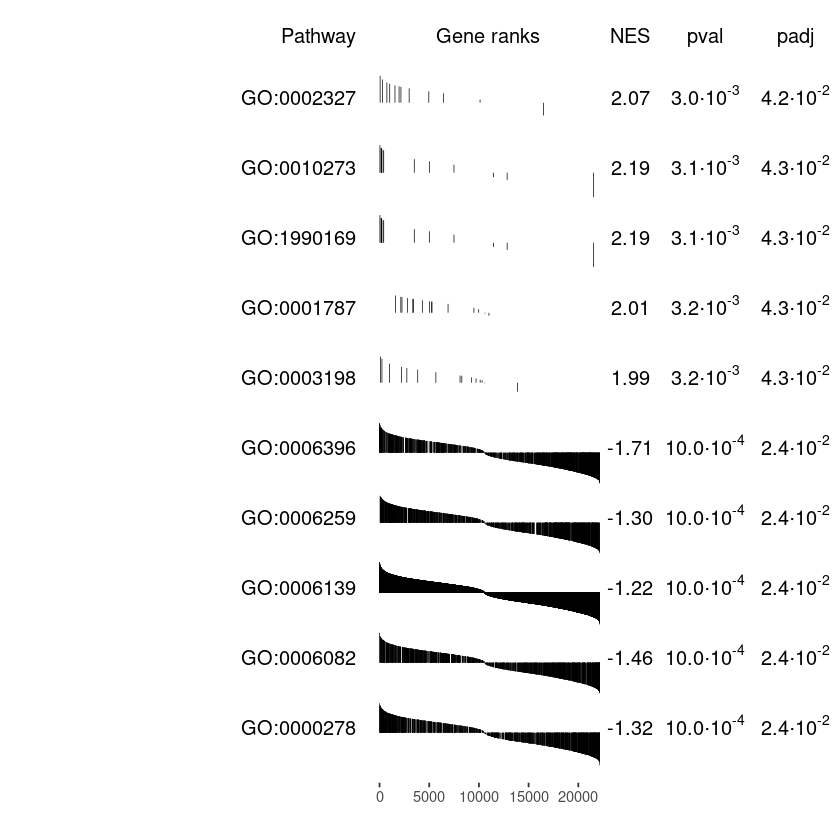

In [31]:
# Get the stats vector for the plotGseaTable
stats <- DE.df$statistic
stats <- as.vector(stats)
names(stats) <- rownames(DE.df)

# select the top five up-regulated pathways 
topPathwaysUp <- fgsea_result[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgsea_result[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = GO_term_hallmark[topPathways], stats = stats, 
              fgseaRes = fgsea_result, gseaParam = 0.5)

To use the `plotGseaTable` function, we need to pass the following arguments:

- `pathways`: A list of pathways to plot table.
- `stats`: A dataframe specifying gene-level stats.
- `fgseaRes`: A dataframe of fgsea results.
- `gseaParam`: A numeric value to adjust displayed statistic values, values closer to 0 flatten plots. Default = 1, value of 0.5 is a good choice too.

### Enrichment analysis using FGSEA and KEGG pathways
We can perform enrichment analysis using FGSEA with KEGG pathway using the same procedure mentioned above. The only thing we need to change is the
list of gene sets that are available in the KEGG database.

In [32]:
# Load the pathways into a named list
KEGG_hallmark <- gmtPathways("./data/KEGG_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(KEGG_hallmark, head)
tmp[1:5]

$hsa00010
[1] "HK3"   "HK1"   "HK2"   "HKDC1" "GCK"   "GPI"  

$hsa00020
[1] "CS"   "ACLY" "ACO2" "ACO1" "IDH1" "IDH2"

$hsa00030
[1] "GPI"  "G6PD" "PGLS" "H6PD" "PGD"  "RPE" 

$hsa00040
[1] "GUSB"    "KL"      "UGT2A1"  "UGT2A3"  "UGT2B17" "UGT2B11"

$hsa00051
[1] "MPI"   "PMM2"  "PMM1"  "GMPPB" "GMPPA" "GMDS"

In [33]:
# Running fgsea analysis
geneset <- KEGG_hallmark
fgsea_result <- runFgsea(DE_data = DE.df, genesets = geneset, nperms = nperms)
# Show some first rows of the result table
head(fgsea_result[order(fgsea_result$pval), c("pathway", "pval", "ES", "NES")])

  |======================================================================| 100%



pathway,pval,ES,NES
<chr>,<dbl>,<dbl>,<dbl>
hsa05022,0.001011122,-0.5520668,-2.210939
hsa05010,0.001020408,-0.5565766,-2.214624
hsa05014,0.001023541,-0.6008541,-2.389612
hsa05016,0.001035197,-0.6102203,-2.401021
hsa05012,0.001047120,-0.6384297,-2.488182
hsa05020,0.001047120,-0.6153209,-2.402092


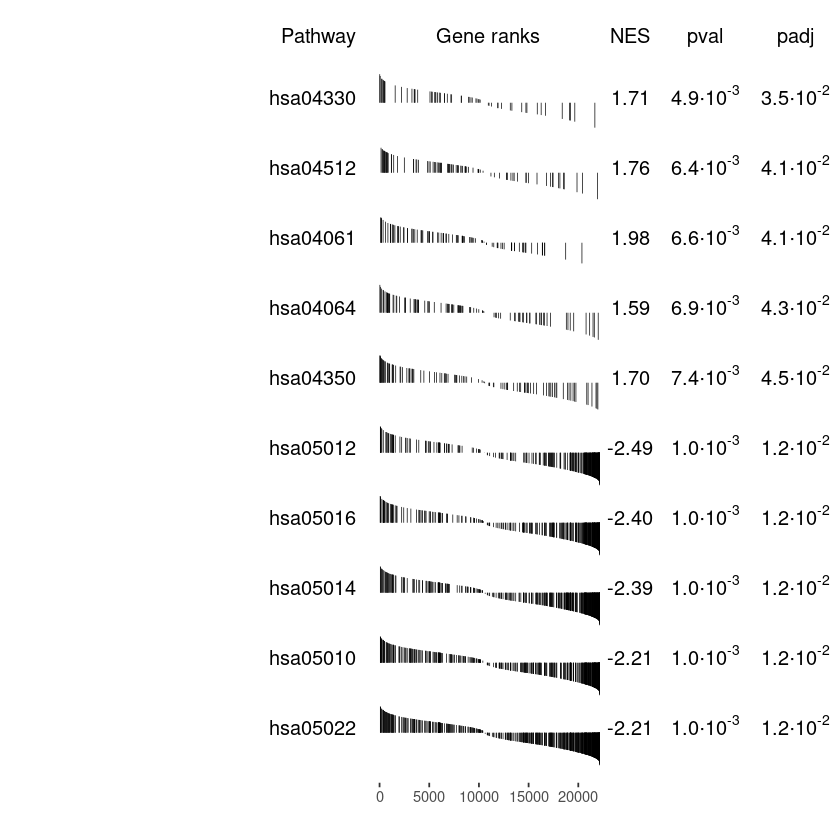

In [34]:
# Get the stats vector for the plotGseaTable
stats <- DE.df$statistic
stats <- as.vector(stats)
names(stats) <- rownames(DE.df)

# select the top five up-regulated pathways 
topPathwaysUp <- fgsea_result[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgsea_result[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = KEGG_hallmark[topPathways], stats = stats, 
              fgseaRes = fgsea_result, gseaParam = 0.5)

### Enrichment analysis using FGSEA and REACTOME pathways
We can perform enrichment analysis using FGSEA with REACTOME pathways using the same procedure above. 

In [35]:
# Load the pathways into a named list
REACTOME_hallmark <- gmtPathways("./data/REACTOME_pathways.gmt")
# Show the first few GO terms, and within those, show only the first few genes.
tmp = lapply(REACTOME_hallmark, head)
tmp[1:5]

$`R-HSA-15869`
[1] "RRM1" "RR1"  "RRM2" "RR2"  "GLRX" "GRX" 

$`R-HSA-68616`
[1] "ORC1"  "ORC1L" "PARC1" "H4C1"  "H4/A"  "H4FA" 

$`R-HSA-68689`
[1] "ORC1"  "ORC1L" "PARC1" "ORC4"  "ORC4L" "ORC5" 

$`R-HSA-68867`
[1] "ORC1"  "ORC1L" "PARC1" "ORC4"  "ORC4L" "ORC5" 

$`R-HSA-68875`
[1] "PLK1"    "PLK"     "GOLGA2"  "GORASP1" "GOLPH5"  "GRASP65"

In [36]:
# Running fgsea analysis
geneset <- REACTOME_hallmark
fgsea_result <- runFgsea(DE_data = DE.df, genesets = geneset, nperms = nperms)
# Show some first rows of the result table
head(fgsea_result[order(fgsea_result$pval), c("pathway", "pval", "ES", "NES")])

  |======================================================================| 100%



pathway,pval,ES,NES
<chr>,<dbl>,<dbl>,<dbl>
R-HSA-73857,0.000999001,-0.3136214,-1.276023
R-HSA-74160,0.000999001,-0.3127066,-1.272720
R-HSA-212436,0.000999001,-0.2989862,-1.216998
R-HSA-392499,0.000999001,-0.4449069,-1.816886
R-HSA-597592,0.000999001,-0.3838094,-1.561330
R-HSA-1430728,0.000999001,-0.4081982,-1.667680


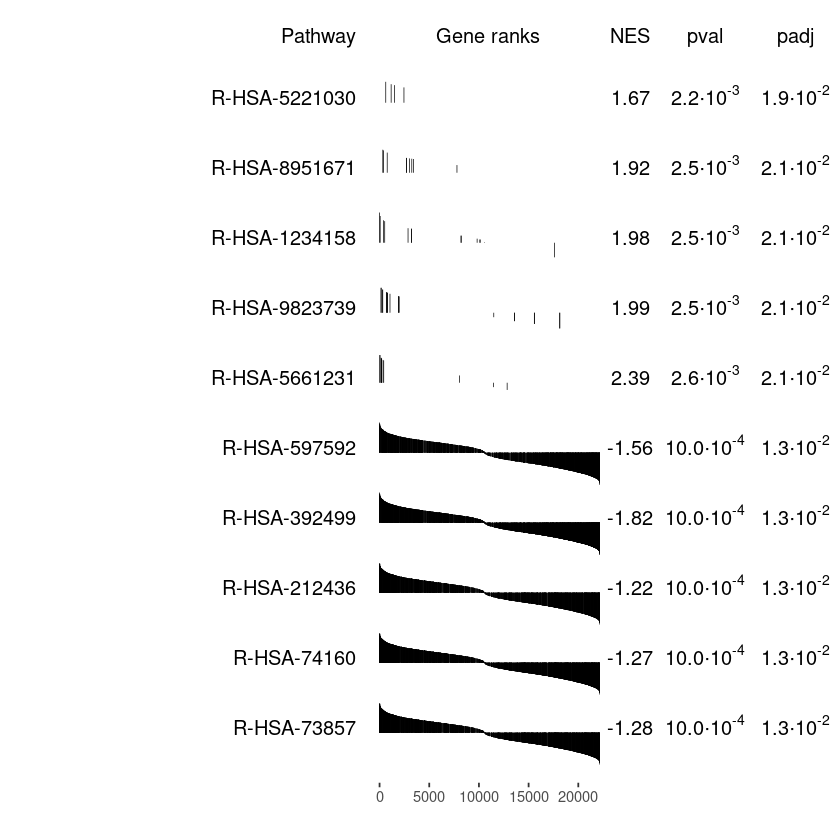

In [37]:
# Get the stats vector for the plotGseaTable
stats <- DE.df$statistic
stats <- as.vector(stats)
names(stats) <- rownames(DE.df)

# select the top five up-regulated pathways 
topPathwaysUp <- fgsea_result[ES > 0][head(order(pval), n = 5), pathway]
# select the top five down-regulated pathways 
topPathwaysDown <- fgsea_result[ES < 0][head(order(pval), n = 5), pathway]
# concatenate them for visualization
topPathways <- c(topPathwaysUp, rev(topPathwaysDown))
#Viewing the 5 most significantly up-regulated and down-regulated pathways each with the FGSEA internal plot function
plotGseaTable(pathways = REACTOME_hallmark[topPathways], stats = stats, 
              fgseaRes = fgsea_result, gseaParam = 0.5)

<!-- headings -->
<a id="gsa-main"></a>
## 5. Enrichment Analysis using GSA

Gene Set Analysis (GSA), an Enrichment Analysis, is a method that is commonly used to summarize high-dimensional gene expression data sets into sets according to their biological relevance. GSA takes the ranked gene lists from the initial stage of a gene expression analysis and aggregates the genes into sets based on shared biological or functional properties as specified by a reference knowledge base. Such databases often contain phenotype associations, molecular interactions and regulation and are referenced in the analysis of the resultant gene sets to find the relevance of the gene properties to the phenotype of interest.

In [38]:
#Run the following command to take the quiz
IRdisplay::display_html('<iframe src="./Quizzes/Quiz_Submodule4-4.html" width=100% height=250></iframe>')

### Data preparation
The GSA method is freely available as standalone package in CRAN repository. We can use the following code to install the package.

In [39]:
# Install GSA from CRAN
suppressMessages({
    suppressWarnings({
        if (!require("GSA")) install.packages("GSA")
    })
})

suppressMessages({
    suppressWarnings({
        library(GSA)
    })
})
# Set the number of permutations
nperms <- 1000

To perform enrichment analysis using GSA, we can use the `runGSA` function below.

In [40]:
#' @description This function performs enrichment analysis using the GSA method.
#'
#' @param exprsData A numeric matrix or a matrix-like object containing gene expression data. Rows represent genes, columns represent samples.
#' @param genesets A list of gene sets to be analzyed.
#' @param groups A factor indicating sample groups.
#' @param parallel A boolean to choose between non-parallel and parallel processing.
#'
#' @return A list containing the GSA results data frame and the GSA object.

runGSA <- function(exprsData, genesets, groups, nperms = 100) {
    # Determine the number of classes in the group variable
    num_classes <- length(unique(groups))
    resp_type <- NULL

    # Check the number of classes and set response type accordingly
    if (num_classes == 1) {
        stop("The group classes in the design matrix must be at least two.")
    } else if (num_classes == 2) {
        resp_type <- "Two class unpaired"
    } else {
        resp_type <- "Multiclass"
    }
    # Run GSA analysis
    gsa_res <- GSA::GSA(
        x = exprsData,
        y = groups,
        genesets = genesets,
        resp.type = resp_type,
        genenames = rownames(exprsData),
        nperms = nperms
    )
        
    # Extract p-values and create result data frame
    pvalues <- apply(cbind(gsa_res$pvalues.lo, gsa_res$pvalues.hi), 1, min)
    res <- data.frame(ID = names(genesets), p.value = pvalues * 2, stringsAsFactors = FALSE)

    # Create GSA result data frame
    GSA_res <- data.frame(
        ID = res$ID,
        p.value = res$p.value,
        score = gsa_res$GSA.scores,
        normalizedScore = gsa_res$GSA.scores,
        stringsAsFactors = FALSE
    )
    # Return a list containing GSA results
    list(GSA_res = GSA_res[!is.na(GSA_res$p.value), ], GSA.obj = gsa_res)
}


The GSA method requires an expression matrix, a numeric vector containing the class of each sample and a vector of the genes inputs. We can easily get those inputs by loading the data that we processed in the [**submodule 01** ](./Submodule01-ProcessingExpressionData.ipynb). From the samples information, we can use the same code in [**submodule 02** ](./Submodule02-DifferentialAnalysis.ipynb) to create the groups information factor.

In [41]:
# Check names available in data
names(data)

[1] "expression_data" "samples"         "genes"           "limma_results"  
[5] "tTest_results"   "edgeR_results"   "deseq2_results"

In [42]:
# Loading expression data and samples information
expression_data <- data$expression_data
samples <- data$samples


Get the groups information for GSA function.

In [43]:
groups <- samples$condition
groups <- as.factor(groups)
groups

[1] c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c
 [38] c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c c
 [75] d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d
[112] d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d d
[149] d d d d d d d d d d d d d
Levels: c d

### Enrichment Analysis using GSA and GO Terms
Using data obtained from the previous step, we can run the GSA method by calling the function `GSA`. We can reuse `GO_term_hallmark` and `KEGG_hallmark` loaded in FGSEA to perform analysis. The code details are shown below:

In [44]:
genesets <- GO_term_hallmark
GSA_output <- runGSA(as.matrix(expression_data), genesets = genesets, as.numeric(groups), nperms = nperms)
# Get GSA_result dataframe and GSA object from output of the runGSA function
GSA_result <- GSA_output$GSA_res
GSA.obj <- GSA_output$GSA.obj

perm= 10 / 1000 
perm= 20 / 1000 
perm= 30 / 1000 
perm= 40 / 1000 
perm= 50 / 1000 
perm= 60 / 1000 
perm= 70 / 1000 
perm= 80 / 1000 
perm= 90 / 1000 
perm= 100 / 1000 
perm= 110 / 1000 
perm= 120 / 1000 
perm= 130 / 1000 
perm= 140 / 1000 
perm= 150 / 1000 
perm= 160 / 1000 
perm= 170 / 1000 
perm= 180 / 1000 
perm= 190 / 1000 
perm= 200 / 1000 
perm= 210 / 1000 
perm= 220 / 1000 
perm= 230 / 1000 
perm= 240 / 1000 
perm= 250 / 1000 
perm= 260 / 1000 
perm= 270 / 1000 
perm= 280 / 1000 
perm= 290 / 1000 
perm= 300 / 1000 
perm= 310 / 1000 
perm= 320 / 1000 
perm= 330 / 1000 
perm= 340 / 1000 
perm= 350 / 1000 
perm= 360 / 1000 
perm= 370 / 1000 
perm= 380 / 1000 
perm= 390 / 1000 
perm= 400 / 1000 
perm= 410 / 1000 
perm= 420 / 1000 
perm= 430 / 1000 
perm= 440 / 1000 
perm= 450 / 1000 
perm= 460 / 1000 
perm= 470 / 1000 
perm= 480 / 1000 
perm= 490 / 1000 
perm= 500 / 1000 
perm= 510 / 1000 
perm= 520 / 1000 
perm= 530 / 1000 
perm= 540 / 1000 
perm= 550 / 1000 
perm= 560 / 1000 
p

In [45]:
head(GSA_result[order(GSA_result$p.value), ])

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
114,GO:0001649,0,0.2904266,0.2904266
123,GO:0001666,0,0.2332024,0.2332024
168,GO:0001822,0,0.2733661,0.2733661
178,GO:0001838,0,0.3340554,0.3340554
650,GO:0006163,0,-0.4718038,-0.4718038
651,GO:0006164,0,-0.6722688,-0.6722688


<div class="alert alert-block alert-danger">
    <i class="fa fa-exclamation-circle" aria-hidden="true"></i>
    <b>Alert: </b>  Please note that the outputs generated from GSA can be varied depending on R environments and software versions. Especially, when the users run the scripts using User-managed Notebooks instances which have a preinstalled suite of packages.
</div>

From the analysis result, we can now get the list positive and negative genes of the GSA analysis from the GSA object using the `GSA.listsets` function. 

In [46]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

To use the `GSA.listsets` function, we need to pass the following arguments:

- `GSA.obj`: A GSA object returned by GSA function.
- `geneset.names`: An optional vector of names for the gene sets.
- `FDRcut`: A numeric value specifying the false discovery rate cutpoint for listed sets. A value of 1 will cause all sets to be listed.

The `GSA.listsets` function returns a list of the results from the GSA call.

A table of the negative gene sets. “Negative” means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [47]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
650,GO:0006163,-0.4718,0,0
651,GO:0006164,-0.6723,0,0
724,GO:0006399,-0.5715,0,0
770,GO:0006520,-0.3463,0,0
864,GO:0006754,-1.267,0,0
981,GO:0007006,-0.6579,0,0


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y.

In [48]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
114,GO:0001649,0.2904,0,0
123,GO:0001666,0.2332,0,0
168,GO:0001822,0.2734,0,0
178,GO:0001838,0.3341,0,0
1682,GO:0014013,0.4147,0,0
1690,GO:0014044,0.7293,0,0


In [49]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = GSA.obj$genenames)

Gene,Score


To use the `GSA.genescores` function, we need to pass the following arguments:

- `geneset.number`: A number specifying which gene set is to be examined.
- `genesets`: A list containing the gene set collection.
- `GSA.obj`: A GSA object returned by the GSA function.
- `genenames`: A vector containing gene names for genes in the expression dataset.

The `GSA.genescores` returns a matrix of gene names and gene scores (eg t-statistics) for each gene in the gene set.


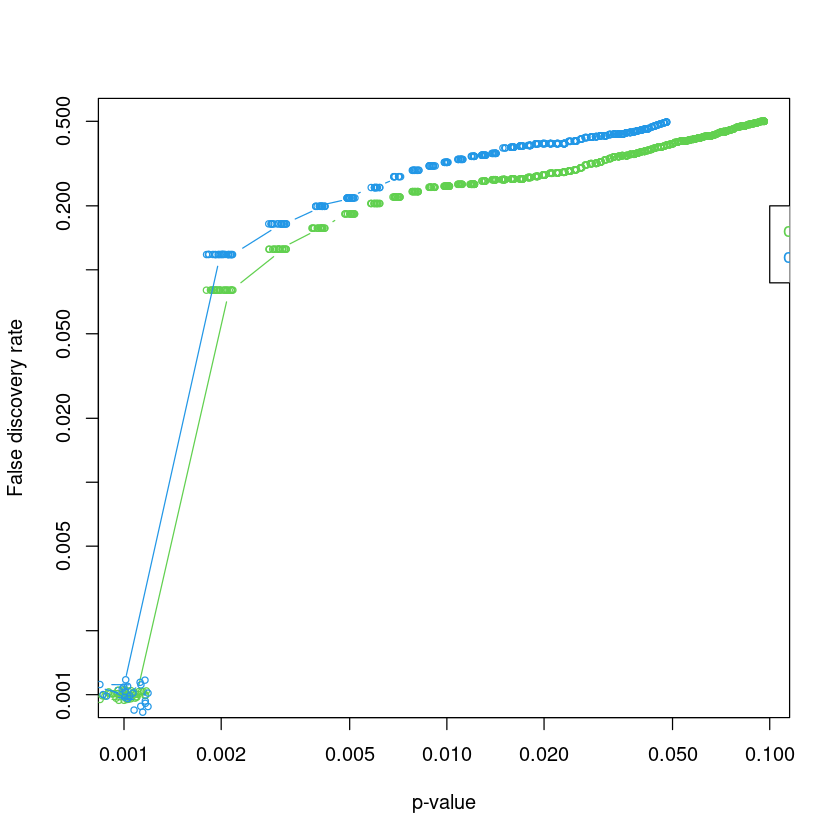

In [50]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))

To use the `GSA.plot` function, we need to pass the following arguments:

- `GSA.obj`: A GSA object returned by the GSA function.
- `fac`: A numeric value for jittering points in plot ("factor" in called to jitter()).
- `FDRcut`: A numeric value specifying the false discovery rate cutpoint for sets to be plotted. A value of 1 (the default) will cause all sets to be plotted.



### Enrichment Analysis using GSA and KEGG pathways
We can use the same procedure to per enrichment analysis with the KEGG pathway. All the codes are similar but `genesets` are assigned from `KEGG_hallmark`. The code is shown below.

In [51]:
genesets <- KEGG_hallmark
GSA_output <- runGSA(as.matrix(expression_data), genesets = genesets, as.numeric(groups), nperms = nperms)
# Get GSA_result dataframe and GSA object from output of the runGSA function
GSA_result <- GSA_output$GSA_res
GSA.obj <- GSA_output$GSA.obj

perm= 10 / 1000 
perm= 20 / 1000 
perm= 30 / 1000 
perm= 40 / 1000 
perm= 50 / 1000 
perm= 60 / 1000 
perm= 70 / 1000 
perm= 80 / 1000 
perm= 90 / 1000 
perm= 100 / 1000 
perm= 110 / 1000 
perm= 120 / 1000 
perm= 130 / 1000 
perm= 140 / 1000 
perm= 150 / 1000 
perm= 160 / 1000 
perm= 170 / 1000 
perm= 180 / 1000 
perm= 190 / 1000 
perm= 200 / 1000 
perm= 210 / 1000 
perm= 220 / 1000 
perm= 230 / 1000 
perm= 240 / 1000 
perm= 250 / 1000 
perm= 260 / 1000 
perm= 270 / 1000 
perm= 280 / 1000 
perm= 290 / 1000 
perm= 300 / 1000 
perm= 310 / 1000 
perm= 320 / 1000 
perm= 330 / 1000 
perm= 340 / 1000 
perm= 350 / 1000 
perm= 360 / 1000 
perm= 370 / 1000 
perm= 380 / 1000 
perm= 390 / 1000 
perm= 400 / 1000 
perm= 410 / 1000 
perm= 420 / 1000 
perm= 430 / 1000 
perm= 440 / 1000 
perm= 450 / 1000 
perm= 460 / 1000 
perm= 470 / 1000 
perm= 480 / 1000 
perm= 490 / 1000 
perm= 500 / 1000 
perm= 510 / 1000 
perm= 520 / 1000 
perm= 530 / 1000 
perm= 540 / 1000 
perm= 550 / 1000 
perm= 560 / 1000 
p

In [52]:
head(GSA_result[order(GSA_result$p.value), ])

,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
208,hsa04919,0.000,0.2927360,0.2927360
293,hsa05165,0.000,0.2114546,0.2114546
323,hsa05017,0.000,-0.6360607,-0.6360607
89,hsa00970,0.002,-0.8201050,-0.8201050
92,hsa03008,0.002,-0.5153641,-0.5153641
98,hsa03050,0.002,-1.5573727,-1.5573727


In [53]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

A table of the negative gene sets. "Negative" means that lower expression of most genes in the gene set correlates with higher values of the phenotype y. E.g., for two classes coded 1,2, lower expression correlates with class 2.

In [54]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
323,hsa05017,-0.6361,0,0
89,hsa00970,-0.8201,0.001,0.0808
92,hsa03008,-0.5154,0.001,0.0808
98,hsa03050,-1.5574,0.001,0.0808
2,hsa00020,-1.0513,0.002,0.0923
322,hsa05016,-0.7777,0.002,0.0923


A table of the positive gene sets. "Positive" means that higher expression of most genes in the gene set correlates with higher values of the phenotype y. See "negative" above for more info.

In [55]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
208,hsa04919,0.2927,0,0
293,hsa05165,0.2115,0,0
124,hsa04350,0.3973,0.001,0.1077
256,hsa05206,0.3308,0.002,0.1615
166,hsa04530,0.2212,0.004,0.1846
196,hsa04920,0.3445,0.004,0.1846


In [56]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = GSA.obj$genenames)

Gene,Score


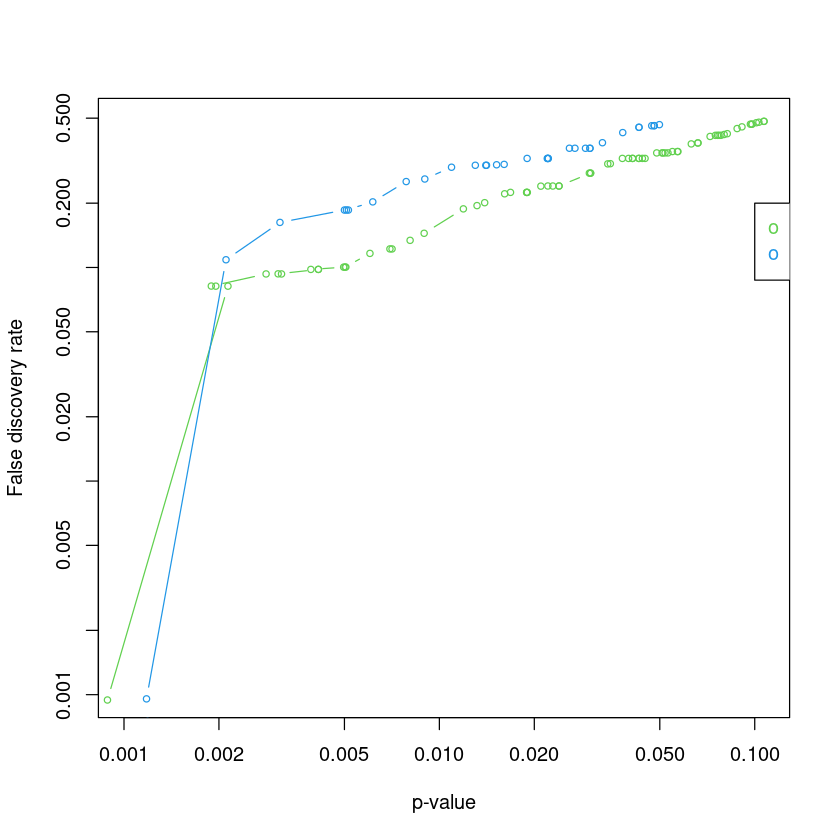

In [57]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))


### Enrichment Analysis using GSA and REACTOME pathways
We can use the same procedure to per enrichment analysis with the REACTOME pathway. All the codes are similar but `genesets` are assigned from `REACTOME_hallmark`. The code is shown below.

In [58]:
genesets <- REACTOME_hallmark
GSA_output <- runGSA(as.matrix(expression_data), genesets = genesets, as.numeric(groups), nperms = nperms)
# Get GSA_result dataframe and GSA object from output of the runGSA function
GSA_result <- GSA_output$GSA_res
GSA.obj <- GSA_output$GSA.obj

perm= 10 / 1000 
perm= 20 / 1000 
perm= 30 / 1000 
perm= 40 / 1000 
perm= 50 / 1000 
perm= 60 / 1000 
perm= 70 / 1000 
perm= 80 / 1000 
perm= 90 / 1000 
perm= 100 / 1000 
perm= 110 / 1000 
perm= 120 / 1000 
perm= 130 / 1000 
perm= 140 / 1000 
perm= 150 / 1000 
perm= 160 / 1000 
perm= 170 / 1000 
perm= 180 / 1000 
perm= 190 / 1000 
perm= 200 / 1000 
perm= 210 / 1000 
perm= 220 / 1000 
perm= 230 / 1000 
perm= 240 / 1000 
perm= 250 / 1000 
perm= 260 / 1000 
perm= 270 / 1000 
perm= 280 / 1000 
perm= 290 / 1000 
perm= 300 / 1000 
perm= 310 / 1000 
perm= 320 / 1000 
perm= 330 / 1000 
perm= 340 / 1000 
perm= 350 / 1000 
perm= 360 / 1000 
perm= 370 / 1000 
perm= 380 / 1000 
perm= 390 / 1000 
perm= 400 / 1000 
perm= 410 / 1000 
perm= 420 / 1000 
perm= 430 / 1000 
perm= 440 / 1000 
perm= 450 / 1000 
perm= 460 / 1000 
perm= 470 / 1000 
perm= 480 / 1000 
perm= 490 / 1000 
perm= 500 / 1000 
perm= 510 / 1000 
perm= 520 / 1000 
perm= 530 / 1000 
perm= 540 / 1000 
perm= 550 / 1000 
perm= 560 / 1000 
p

In [59]:
head(GSA_result[order(GSA_result$p.value), ])


,ID,p.value,score,normalizedScore
,<chr>,<dbl>,<dbl>,<dbl>
12,R-HSA-68949,0,-0.9963624,-0.9963624
17,R-HSA-69052,0,-0.7561771,-0.7561771
33,R-HSA-69275,0,-0.5155144,-0.5155144
146,R-HSA-75815,0,-1.2151492,-1.2151492
464,R-HSA-180534,0,-1.2363423,-1.2363423
646,R-HSA-349425,0,-1.2271178,-1.2271178


In [60]:
# List the results from a GSA analysis
res <- GSA.listsets(GSA.obj = GSA.obj, geneset.names = names(genesets), FDRcut = .5)

In [61]:
neg.table <- res$negative
head(neg.table)

Gene_set,Gene_set_name,Score,p-value,FDR
12,R-HSA-68949,-0.9964,0,0
17,R-HSA-69052,-0.7562,0,0
33,R-HSA-69275,-0.5155,0,0
146,R-HSA-75815,-1.2151,0,0
464,R-HSA-180534,-1.2363,0,0
646,R-HSA-349425,-1.2271,0,0


In [62]:
pos.table <- res$positive
head(pos.table)

Gene_set,Gene_set_name,Score,p-value,FDR
647,R-HSA-350054,1.0291,0,0
1181,R-HSA-1912399,1.8034,0,0
1734,R-HSA-5633008,0.7252,0,0
1933,R-HSA-6803207,1.6304,0,0
1943,R-HSA-6804758,0.679,0,0
2159,R-HSA-9013406,0.5936,0,0


In [63]:
# Individual gene scores from a gene set analysis
# look at 10th gene set
GSA.genescores(geneset.number = 10, genesets = genesets, 
               GSA.obj = GSA.obj, genenames = GSA.obj$genenames)

Gene,Score


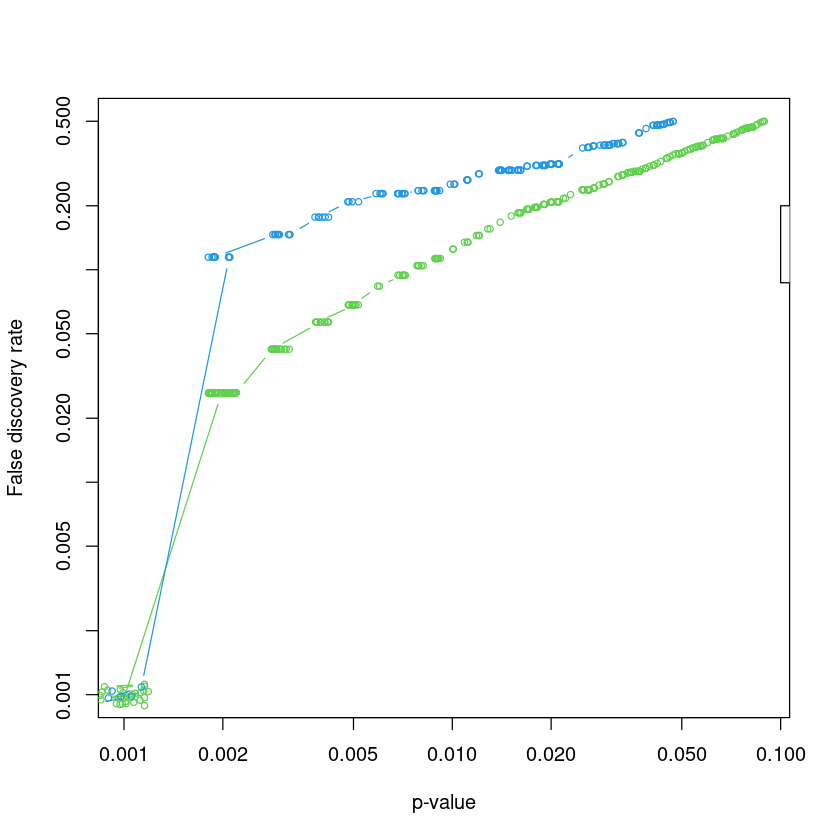

In [64]:
# Plot the result, this function makes a plot of the significant gene sets, based on a call to the GSA (Gene set analysis) function.
suppressWarnings(GSA.plot(GSA.obj, fac = 1, FDRcut = 0.5))


<!-- headings -->
<a id="safe-main"></a>
## 6. Enrichment Analysis using SAFE


Similar to the CAMERA method, the Significance Analysis of Function and Expression (SAFE) method also has two stages. First, it calculates local statistics to measure the significance of each gene's association in the dataset, using tests like the Student’s t-test, Welch’s t-test, t-statistic from a linear model, etc. In the second stage, it computes global statistics to assess the significance of a competitive hypothesis test for each gene set or pathway. These global statistics, including Wilcoxon rank sum, Fisher’s Exact Test, Pearson’s Chi-squared type statistic, and a t-statistic for average difference, help compare various gene sets. To control the false positives rate, SAFE uses permutation of class labels.

We can use the function `safe` from the bioconductor `safe` package to perform EA using this method. We first need to install and import the required packages.

In [73]:
# Install and import safe 
suppressWarnings({
    suppressMessages({
        if (!require("BiocManager", quietly = TRUE))
            install.packages("BiocManager")
        
        BiocManager::install("safe")
        
        library(safe)
        library(hgu133plus2.db)
    })
})

nperms <- 1000

The `runSAFE` function below requires a gene expression matrix, a list of gene sets, and the group information of the expression matrix. It utilizes the `getCmatrix` and `safe` functions to perform enrichment analysis using the SAFE method. The `getCmatrix` function creates a matrix from a genes list of a dataset and a list of gene sets. This matrix will be used as an input of the `safe` function. 

In [74]:
#' @description This function performs enrichment analysis using the SAFE method.
#'
#' @param exprsData A numeric matrix or a matrix-like object containing gene expression data. Rows represent genes, columns represent samples.
#' @param genesets A list of gene sets to be analyzed.
#' @param groups A factor indicating sample groups.
#' @param nperms An integer specifying the number of permutations for assessing significance (default is 1000).
#' @param seed An integer specifying a seed for reproducibility of permutation results (default is 1).
#'
#' @return A data frame containing pathway IDs and corresponding p-values.
runSAFE <- function(exprsData, geneSet, groups, nperms = 1000, seed = 42) { 
    set.seed(seed)
    # Create the C matrix from the list of gene sets and list of gene IDs in the expression data
    C.mat2<- getCmatrix(keyword.list = geneSet, present.genes = rownames(exprsData))
    # Perform enrichment analysis using the safe function
    results<- safe(as.matrix(exprsData), groups, C.mat = C.mat2, 
                   platform = "hgu133plus2.db", Pi.mat = nperms, 
                   print.it =FALSE)
    # Extract the analysis result
    res <- safe.toptable(results, number = length(geneset))
    return(res)
}

### Enrichment Analysis using SAFE and GO terms 
We can perform SAFE enrichment analysis with GO terms using the following commands.

In [75]:
# Get the GO terms, which is previously loaded for the FGSEA method
geneset <- GO_term_hallmark
# Perform the analysis using SAFE
res <- runSAFE(exprsData = expression_data, geneSet = geneset, groups = groups, nperms = nperms)
head(res)

6938 categories formed


Loading required package: GO.db





,GenesetID,Size,Statistic,P.value,Adj.p.value,Description
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,GO:0008150,16607,192914032,0.001,0.0263,biological_process
2,GO:0009987,15533,181224552,0.001,0.0263,cellular process
3,GO:0065007,11519,132810292,0.001,0.0263,biological regulation
4,GO:0008152,10947,130302948,0.001,0.0263,metabolic process
5,GO:0050789,11133,128366379,0.001,0.0263,regulation of biological process
6,GO:0071704,10471,124357436,0.001,0.0263,organic substance metabolic process


### Enrichment Analysis using SAFE and KEGG pathways
We can use the same command as for GO terms. We just need to pass the KEGG pathways instead of GO terms.

In [76]:
# Get the KEGG pathways
geneset <- KEGG_hallmark
# Perform the analysis using SAFE
res <- runSAFE(exprsData = expression_data, geneSet = geneset, groups = groups, nperms = nperms)
head(res)

345 categories formed


,GenesetID,Size,Statistic,P.value,Adj.p.value,Description
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,hsa05016,295,4537306,0.001,0.0265,NA
2,hsa05012,258,4099081,0.001,0.0265,NA
3,hsa04714,226,3313828,0.001,0.0265,NA
4,hsa05132,246,3250270,0.001,0.0265,NA
5,hsa04144,250,3170370,0.001,0.0265,NA
6,hsa05017,141,2136820,0.001,0.0265,NA


### Enrichment Analysis using SAFE and REACTOME pathways 
We can do the same as GO terms and KEGG pathways. 

In [77]:
# Get the REACTOME pathways
geneset <- REACTOME_hallmark
# Perform the analysis using SAFE
res <- runSAFE(exprsData = expression_data, geneSet = geneset, groups = groups, nperms = nperms)
head(res)



2358 categories formed


,GenesetID,Size,Statistic,P.value,Adj.p.value,Description
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,R-HSA-74160,1543,19343870,0.001,0.0187,NA
2,R-HSA-73857,1372,17159119,0.001,0.0187,NA
3,R-HSA-212436,1249,15517696,0.001,0.0187,NA
4,R-HSA-8953854,733,10323614,0.001,0.0187,NA
5,R-HSA-5653656,710,9248109,0.001,0.0187,NA
6,R-HSA-1640170,697,8981615,0.001,0.0187,NA


<!-- headings -->
<a id="padog-main"></a>
## 7. Enrichment Analysis using PADOG

Pathway Analysis with Down-weighting of Overlapping Genes (PADOG) is a specialized method for enrichment analysis. Focused on deciphering the functional implications of differentially expressed genes in biological pathways, PADOG uniquely emphasizes the uniqueness of genes. Its down-weighting mechanism enhances precision by addressing challenges posed by overlapping genes, offering valuable insights into specific pathways influenced by gene expression changes.

To perform PADOG enrichment analysis, we will use the "PADOG" package. We first need to install and load the package.

In [78]:
suppressWarnings({
    suppressMessages({
        if (!require("BiocManager", quietly = TRUE)) {
            install.packages("BiocManager")
        }
        BiocManager::install("PADOG")
    })
})

suppressWarnings({suppressMessages({library(PADOG)})})

nperms <- 1000

We will use the `runPadog` function below to perform enrichment analysis using `PADOG` package. This function requires a gene expression matrix, a list of gene sets to analyze and the group information of the dataset. It will return the analysis results in a dataframe.

In [79]:
#' @description This function performs enrichment analysis using the PADOG method.
#'
#' @param exprsData A numeric matrix or a matrix-like object containing gene expression data. Rows represent genes, columns represent samples.
#' @param genesets A list of gene sets to be analzyed.
#' @param groups A factor indicating sample groups.
#' @param nperms An integer specifying the number of permutations for assessing significance (default is 100).
#' @param seed An integer specifying a seed for reproducibility of permutation results (default is 1).
#' @param ncores An integer specifying the number of cores to use for parallel processing (default is 100).
#'
#' @return A data frame containing pathway IDs and corresponding p-values.

runPadog <- function(exprsData, geneSet, groups, perm = 100, seed = 1, ncores = 1) {
    # Run PADOG analysis
    res <- PADOG::padog(
        esetm = as.matrix(exprsData),
        group = groups,
        gslist = geneSet,
        annotation = NULL,
        gs.names = names(geneSet),
        NI = nperms,
        plots = FALSE,
        targetgs = NULL,
        dseed = seed,
        parallel = TRUE,
        ncr = ncores
    )
    # Extract relevant columns and rename
    res <- res[, c('ID', 'Ppadog')]
    colnames(res) <- c("pathway", "p.value")
    
    return(res)
}


The PADOG method requires inputs that are quite similar to the GSA method. Thus, to perform analysis using PADOG, we will use the previously preprocessed `new_expression_data` dataframe and `groups` information for the GSA method above.

### Enrichment Analysis using PADOG and GO terms

In [80]:
# Assign the geneset variable to GO_term_hallmark loaded in previous code
geneset <- GO_term_hallmark
# Perform PADOG enrichment analysis using the runPadog function
PADOG_result <- runPadog(exprsData = expression_data, geneSet = geneset, 
                         groups = groups, perm = nperms, seed = 1)

head(PADOG_result)

Starting with 6938 gene sets!
Analyzing 6938 gene sets with 3 or more genes!
# of permutations used: 1000 


,pathway,p.value
,<chr>,<dbl>
GO:0009144,GO:0009144,1e-05
GO:0007005,GO:0007005,1e-05
GO:0009205,GO:0009205,1e-05
GO:0009152,GO:0009152,1e-05
GO:0009141,GO:0009141,1e-05
GO:0009199,GO:0009199,1e-05


### Enrichment Analysis using PADOG and KEGG pathways

We can use the same procedure to perform enrichment analysis with the GO terms. All the codes are similar but the gene sets list is loaded from `KEGG`. The code is shown below.

In [81]:
# Assign the geneset variable to KEGG_hallmark loaded in previous code
geneset <- KEGG_hallmark
# Perform PADOG enrichment analysis using the runPadog function
PADOG_result <- runPadog(exprsData = expression_data, geneSet = geneset, 
                         groups = groups, perm = nperms, seed = 1)

head(PADOG_result)

Starting with 345 gene sets!
Analyzing 344 gene sets with 3 or more genes!
# of permutations used: 1000 


,pathway,p.value
,<chr>,<dbl>
hsa05016,hsa05016,1e-05
hsa05012,hsa05012,1e-05
hsa05020,hsa05020,1e-05
hsa05017,hsa05017,1e-05
hsa03050,hsa03050,1e-03
hsa05010,hsa05010,2e-03


### Enrichment Analysis using PADOG and REACTOME pathways

We will apply the same code that has been used for the GO terms and KEGG pathways.

In [82]:
# Assign the geneset variable to REACTOME_hallmark loaded in previous code
geneset <- REACTOME_hallmark
# Perform PADOG enrichment analysis using the runPadog function
PADOG_result <- runPadog(exprsData = expression_data, geneSet = geneset, 
                         groups = groups, perm = nperms, seed = 1)

head(PADOG_result)

Starting with 2673 gene sets!
Analyzing 2234 gene sets with 3 or more genes!
# of permutations used: 1000 


,pathway,p.value
,<chr>,<dbl>
R-HSA-69275,R-HSA-69275,1e-05
R-HSA-453274,R-HSA-453274,1e-05
R-HSA-5610787,R-HSA-5610787,1e-05
R-HSA-162909,R-HSA-162909,1e-05
R-HSA-450531,R-HSA-450531,1e-05
R-HSA-69202,R-HSA-69202,1e-05


The next submodule will go indepth about meta analysis.

In [83]:
sessionInfo()

R version 4.3.2 (2023-10-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3 
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/libopenblasp-r0.3.13.so;  LAPACK version 3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats4    parallel  stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] PADOG_1.44.0             KEGGdzPathwaysGEO_1.40.0 GO.db_3.18.0            
 [4] doRNG_1.8.6              rngtools_1.5.2           foreach_1.5.2           
 [7] hgu133plus2.db_3.13.0    org